# Demonstration of CG building of linear polymer chains

In [1]:
# logging tools
import logging
logging.basicConfig(level=logging.WARNING)

from rich.progress import Progress, BarColumn, TimeRemainingColumn
def build_progress() -> Progress:
    return Progress(
        "[progress.description]{task.description}",
        BarColumn(),
        "(polymer {task.completed}/{task.total})",
        TimeRemainingColumn(),
        "Placing {task.fields[chain_len]}-mer chain",
        auto_refresh=False,
    )

# library imports
import numpy as np
from scipy.spatial.transform import Rotation, RigidTransform

from rdkit.Chem import Mol, MolFromSmiles, AddHs
from rdkit.Chem.rdMolTransforms import TransformConformer
from rdkit.Chem.AllChem import EmbedMolecule

from mupt.geometry.coordinates.reference import CoordAxis
from mupt.geometry.transforms.rigid import rigid_vector_coalignment

In [2]:
POS_1_IDX : int = 1
POS_2_IDX : int = 2

def mol_aligned_to_axis(smiles : str, axis : CoordAxis=CoordAxis.X) -> tuple[Mol, int, int]:
    '''
    Initialize a Mol with a pair of marked positions pinned to the x-axis, equidistant from the origin
    Returns the mol (with associated conformer), the bound conformer ID, and the semi-axis length
    '''
    mol = MolFromSmiles(smiles, sanitize=True)
    mol = AddHs(mol)
    conf_id : int = EmbedMolecule(mol) # positions are determined here
    conf = mol.GetConformer(conf_id)

    span_atom_pos : dict[str, np.ndarray] = {}
    for atom in mol.GetAtoms():
        if (map_num := atom.GetAtomMapNum()):
            span_atom_pos[map_num] = conf.GetAtomPosition(atom.GetIdx())
    pos1 = np.array(span_atom_pos[POS_1_IDX])
    pos2 = np.array(span_atom_pos[POS_2_IDX])
    
    semimajor = np.linalg.norm(pos2 - pos1) / 2.0
    axis_vec = np.zeros(3, dtype=float)
    axis_vec[axis.value] = semimajor
    
    axis_alignment = rigid_vector_coalignment(
        vector1_start=pos1,
        vector1_end=pos2,
        vector2_start=np.zeros(3, dtype=float),
        vector2_end=axis_vec,
        t1=1/2,
        t2=0.0,
    )
    TransformConformer(conf, trans=axis_alignment.as_matrix())

    return mol, conf_id, semimajor

## Compile lexicon of unit repeat units (with fitted Ellipsoidal shapes)
Rigidly moves each set of atoms defining the repeat units to lie along the chosen axis; this is a "reference" orientation  

In this example, ths sizes of the beads are chosen to match the inter-atom distance defined by the atomic conformer;   
In the future, this relationship will be inverted, i.e. first setting the bead size, then pinning the pair of anchor atoms that distance apart while relaxing the interior of the conformer

In [3]:
AXIS : CoordAxis = CoordAxis.X
ORIGIN : np.ndarray = np.array([0.0, 0.0, 0.0], dtype=float)
SEMIMINOR_FRACT : float = 0.5 # how long the pair of minor axes should be as a fraction of the major axis length

head


[15:16:41] UFFTYPER: Unrecognized atom type: *_ (16)


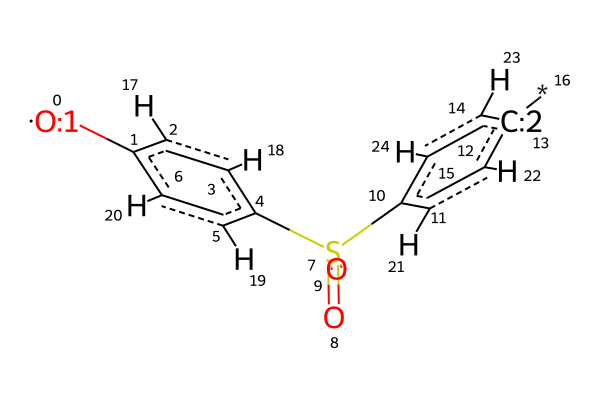

mid


[15:16:41] UFFTYPER: Unrecognized atom type: *_ (0)
[15:16:41] UFFTYPER: Unrecognized atom type: *_ (17)


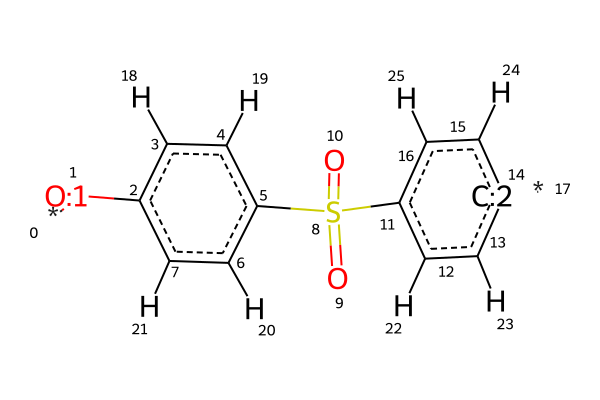

tail


[15:16:42] UFFTYPER: Unrecognized atom type: *_ (0)


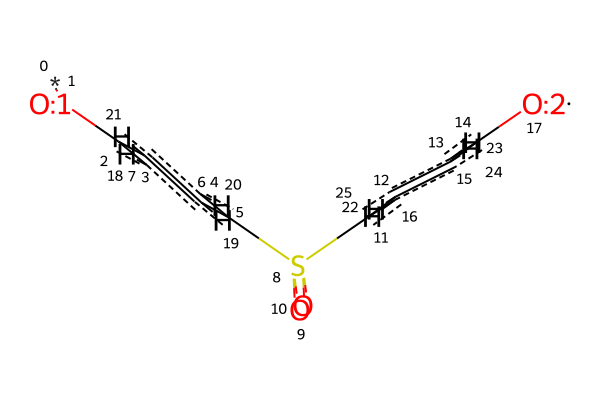

In [4]:
from mupt.mupr.primitives import Primitive
from mupt.geometry.shapes import PointCloud, Ellipsoid
from mupt.interfaces.rdkit import primitive_from_rdkit


rep_unit_smiles : dict[str, str] = {
    'head' : f'[O:{POS_1_IDX}]c1ccc(cc1)S(=O)(=O)c1cc[c:{POS_2_IDX}](cc1)-*',
    'mid'  : f'*-[O:{POS_1_IDX}]c1ccc(cc1)S(=O)(=O)c1cc[c:{POS_2_IDX}](cc1)-*',
    'tail' : f'*-[O:{POS_1_IDX}]c1ccc(cc1)S(=O)(=O)c1ccc(cc1)[O:{POS_2_IDX}]',
}
CHAIN_LINK_ORIENT : tuple[str, str] = ('A', 'B') # NOTE: literally doesn't matter what these are, as long as they're distinct and hashable
rep_unit_connection_tags : dict[str, tuple[tuple[str, str], ...]] = {
    'head' : [CHAIN_LINK_ORIENT],
    'mid'  : [CHAIN_LINK_ORIENT[::-1], CHAIN_LINK_ORIENT],
    'tail' : [CHAIN_LINK_ORIENT[::-1]],
}

lexicon : dict[str, Primitive] = {}
for unit_name, smiles in rep_unit_smiles.items():
    mol, conf_id, semimajor = mol_aligned_to_axis(smiles, axis=AXIS)
    semiminor = SEMIMINOR_FRACT * semimajor
    print(unit_name)
    display(mol)

    prim = primitive_from_rdkit(mol, conformer_idx=conf_id, label=unit_name)
    for chain_tags, connector in zip(rep_unit_connection_tags[unit_name], prim.connectors.values(), strict=True):
        connector.anchor = chain_tags[0]
        connector.linkables = {chain_tags[1]}

    radii = np.full(3, semiminor)
    radii[AXIS.value] = semimajor
    prim.shape = Ellipsoid(radii)

    lexicon[unit_name] = prim

## Construct hierarchy of Primitives representing polymer system
Hierarchy constructed here corresponds to abox of homopolymer chains with a given distribution of lengths;  
any given branch traced through the hierarchy is structured as Universe -> chains -> repeat units -> atoms

Each chain's units begin in reference position (i.e. level and centered at origin) initially, and are then placed by a placement generator  
An angle-constrained random walk is provided as an example implementation, but other implementations (e.g. DPD) can be slotted in just as easily by replacing the kind of builder user

In [5]:
# configure system parameters
R_excl : float = 10.0
n_chains : int = 1#6
dop_min : int = 15 # must be at least 2!
dop_max : int = 25

Output()

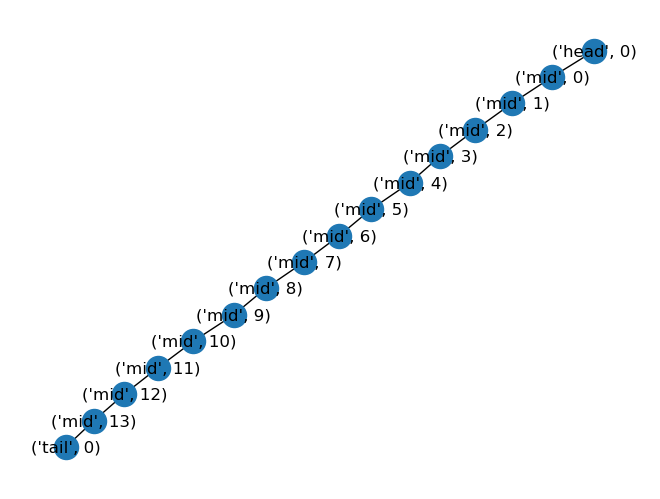

In [6]:
import networkx as nx
from mupt.mupr.topology import TopologicalStructure

from mupt.builders.random_walk import AngleConstrainedRandomWalk
from mupt.geometry.coordinates import origin
from mupt.geometry.coordinates.directions import random_unit_vector
from time import sleep

univprim = Primitive(label='universe')
with build_progress() as progress:
    task = progress.add_task('Building chains', total=n_chains, chain_len=0)
    for chain_len in np.random.randint(dop_min, dop_max + 1, size=n_chains):
        progress.update(task, chain_len=chain_len)
        
        # build chain hierarchy
        molprim = Primitive(label='polymer_chain')
        unit_names : list[str] = ['head'] + ['mid']*(chain_len - 2) + ['tail']
        for i, unit_name in enumerate(unit_names)   :
            rep_unit_prim = lexicon[unit_name].copy()
            molprim.attach_child(rep_unit_prim)
        molprim.topology = nx.path_graph(molprim.children_by_handle.keys(), create_using=TopologicalStructure)
        
        # place beads by randow walk (other build implementations would go here)
        direction = random_unit_vector()
        builder = AngleConstrainedRandomWalk(
            bond_length=1.5,
            angle_max_rad=np.pi/4,
            initial_point=R_excl*direction, # this is also the default, but just illustrates that you can start the walk anywhere
            initial_direction=direction,  # randomize (also default)
        )
        for handle, placement in builder.generate_placements(molprim):
            molprim.children_by_handle[handle].rigidly_transform(placement)
            
        # attach chain to universe, expand to show topology of beads
        mol_handle = univprim.attach_child(molprim)
        univprim.expand(mol_handle)
        
        progress.advance(task)
        progress.refresh()

univprim.topology.visualize()

## Flatten Primitive hierarchy and export as all-atom system
Expand each level until the hierarchy is just leaves below a root (atoms in a molecule system), then write out to RDKit

In [7]:
from rdkit.Chem import MolToMolFile
from mupt.interfaces.rdkit import primitive_to_rdkit


save_path : str = 'ellipsoidal_PPS_chain.mol'
chain : Mol = primitive_to_rdkit(univprim.copy()) # make copy for export, as flattening is done in-place

MolToMolFile(chain, save_path)
print(f'Exported {chain.GetNumAtoms()}-atom system to {save_path}')

Exported 385-atom system to ellipsoidal_PPS_chain.mol


## Visualize placement of subprimitives [slow for larger systems, can skip if desired]
Visualize co-levels in hierarchy and plot residues (as Ellipsoids here) and individual atoms (as single points)

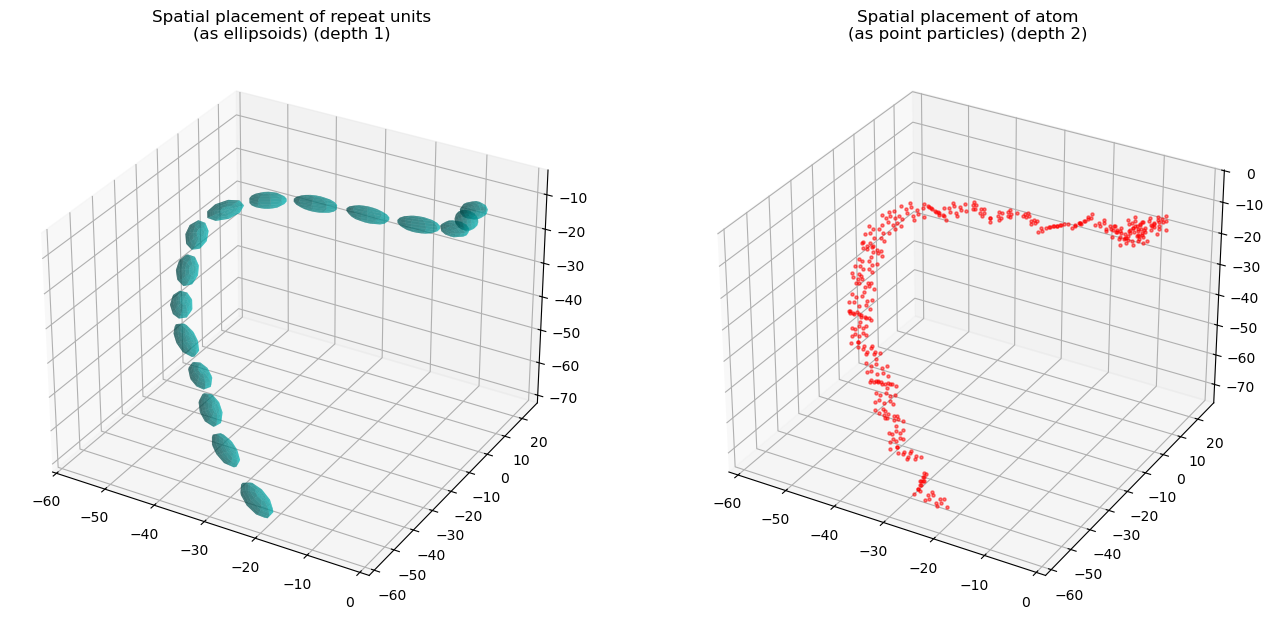

In [8]:
# NBVAL_SKIP
from anytree.iterators import LevelOrderGroupIter

import matplotlib.pyplot as plt
# %matplotlib ipympl

scale : float=16
aspect : float = 1/2
plt.close()
fig = plt.figure(figsize=(scale, scale*aspect))
fig.canvas.header_visible = False

levels : dict[int, tuple[Primitive]] = {i : grp for i, grp in enumerate(LevelOrderGroupIter(univprim))}

ellip_depth : int = 1
ax_ellip = fig.add_subplot(1, 2, ellip_depth, projection='3d')
ax_ellip.autoscale(enable=True)
ax_ellip.set_title(f'Spatial placement of repeat units\n(as ellipsoids) (depth {ellip_depth})')
for res_prim in levels[ellip_depth]:
    _ = ax_ellip.plot_surface(*res_prim.shape.surface_mesh(10, 10).T, color='c', alpha=0.5)

atom_depth : int = 2
ax_atomic = fig.add_subplot(1, 2, atom_depth, projection='3d')
ax_atomic.autoscale(enable=True)
ax_atomic.set_title(f'Spatial placement of atom\n(as point particles) (depth {atom_depth})')
for res_prim in levels[atom_depth]:
    _ = ax_atomic.scatter(*res_prim.shape.positions.T, color='r', marker='.', alpha=0.5)

In [9]:
# # optional; can apply a rigid transformation to the ENTIRE molecule at once - 
# random_rot = RigidTransform.from_rotation(Rotation.random())
# univprim.rigidly_transform(random_rot)